# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Load Dataset

In [2]:
# Load the dataset
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')

# Display the first few rows
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
# Make date column as index
train_df.set_index('date', inplace=True)

# Convert date from object to datetime format
train_df.index = pd.to_datetime(train_df.index, format='%Y-%m-%d', errors='coerce')

# Exploratory Data Analysis

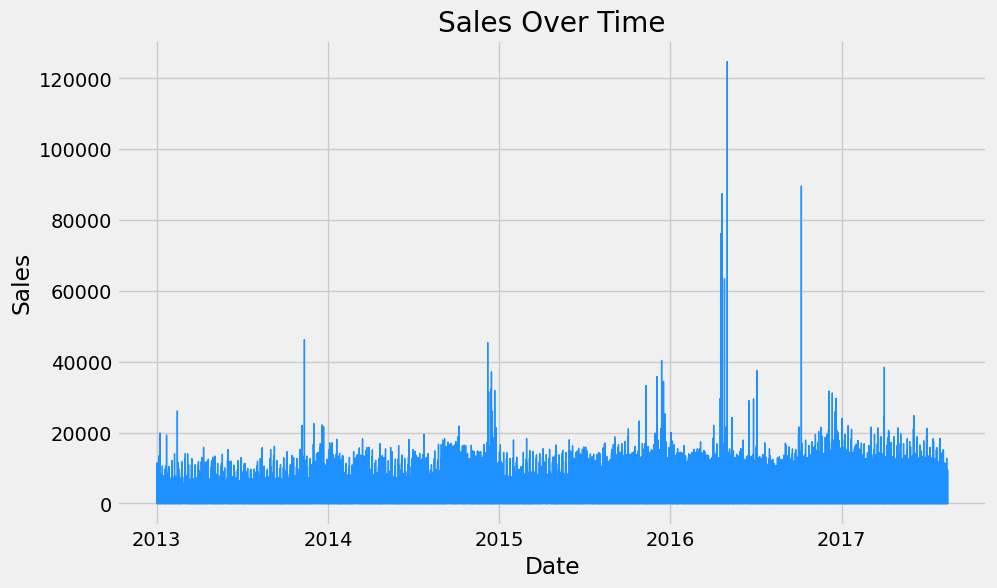

In [4]:
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['sales'], color='dodgerblue', linewidth=1)
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [5]:
# Get the maximum sales value
max_sales = train_df['sales'].max()

# Get the date corresponding to the highest sales value
max_sales_date = train_df['sales'].idxmax()

# Print the results
print(f'The highest sales value is {max_sales} on {max_sales_date}')


The highest sales value is 124717.0 on 2016-05-02 00:00:00


## Scatter Plot
The scatter plot shows that most sales occur when fewer items are on promotion. There’s no clear linear relationship between promotions and sales. While promotions seem to influence sales to some extent, sales don't significantly increase after around 100 promotions, suggesting diminishing returns. Outliers exist where sales spike even with relatively low promotions.



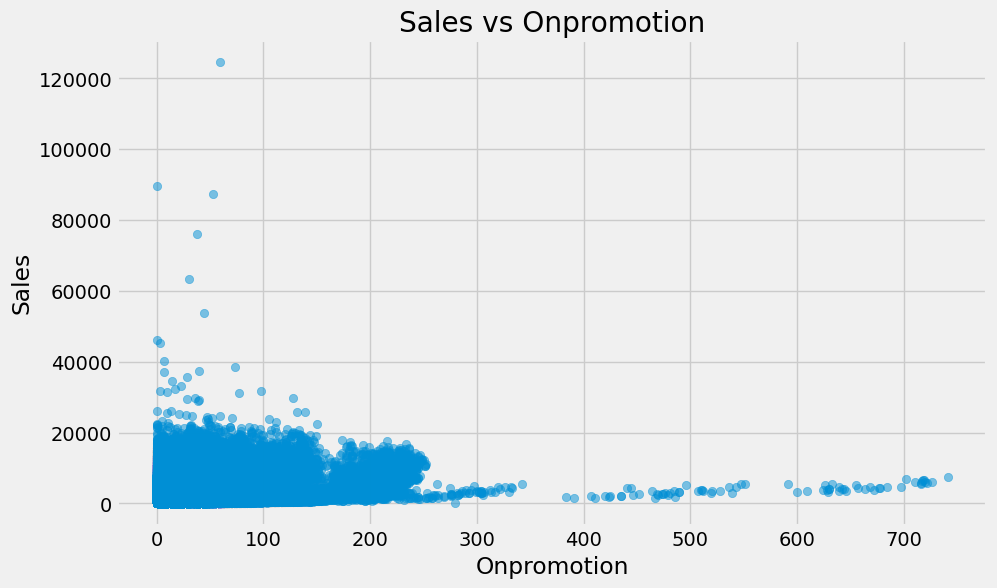

In [6]:
import matplotlib.pyplot as plt

# Scatter plot of 'onpromotion' vs. 'sales'
plt.figure(figsize=(10, 6))
plt.scatter(train_df['onpromotion'], train_df['sales'], alpha=0.5)
plt.title('Sales vs Onpromotion')
plt.xlabel('Onpromotion')
plt.ylabel('Sales')
plt.show()


## Correlation Matrix
The correlation matrix reveals several important relationships in the dataset. There is a moderate positive correlation between sales and the number of items on promotion (0.43), indicating that promotions have some impact on increasing sales. The year and ID have a very high correlation (0.98), suggesting a strong temporal pattern and potential redundancy between these two variables. Additionally, there is a high correlation between date-related variables, such as `day_of_year`, `month`, and `quarter`, which indicates multicollinearity. This means that these variables are capturing similar information, and including all of them in the model might not be necessary.

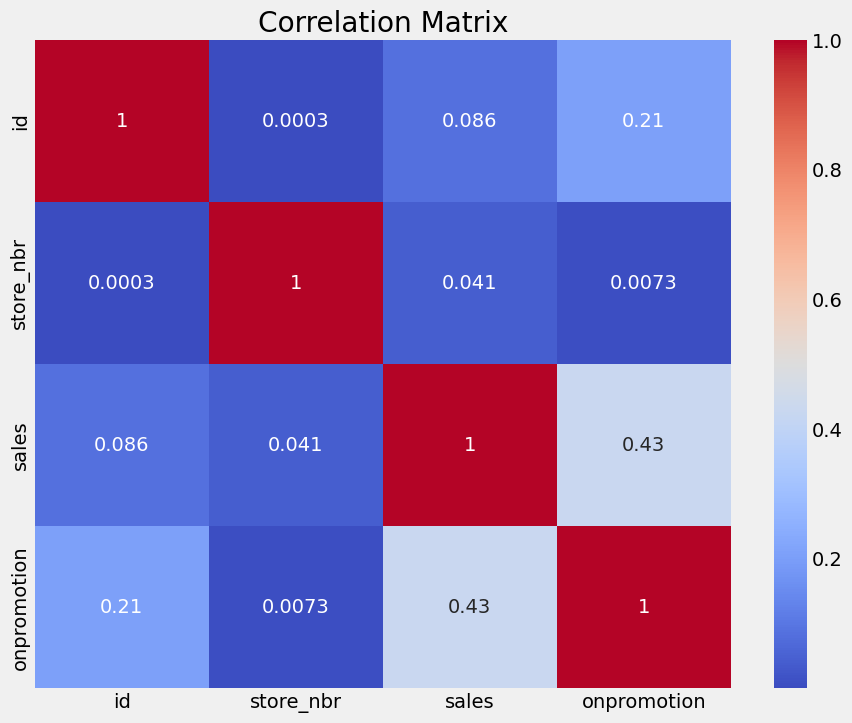

In [7]:
import seaborn as sns
plt.figure(figsize=(10, 8))

# Select only numeric columns
numeric_df = train_df.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Lag Plot

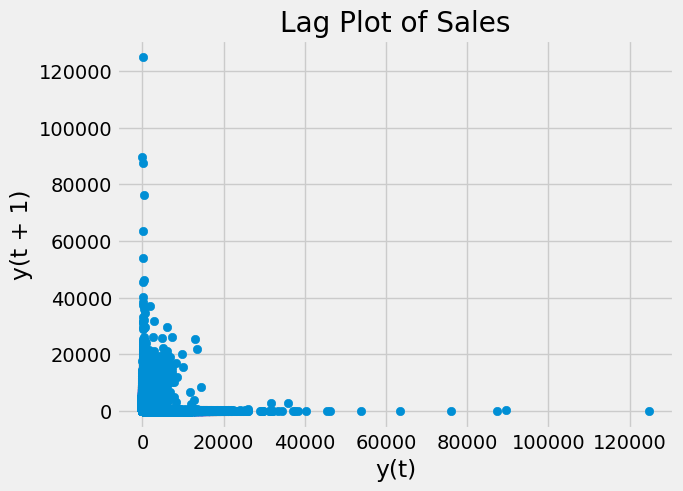

In [8]:
from pandas.plotting import lag_plot
lag_plot(train_df['sales'])
plt.title('Lag Plot of Sales')
plt.show()


# Data Preprocessing

In [9]:
# Handling missing values
train_df.fillna(0, inplace=True)

# Encoding categorical features
encoder = LabelEncoder()
train_df['family'] = encoder.fit_transform(train_df['family'])

# Feature engineering: extract year, day of year, month, day, and day of week
train_df['year'] = train_df.index.year
train_df['day_of_year'] = train_df.index.dayofyear
train_df['month'] = train_df.index.month
train_df['day'] = train_df.index.day
train_df['day_of_week'] = train_df.index.dayofweek

# Features and target
X = train_df.drop(['sales', 'id'], axis=1)
y = train_df['sales']


# Train-test Split

In [10]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

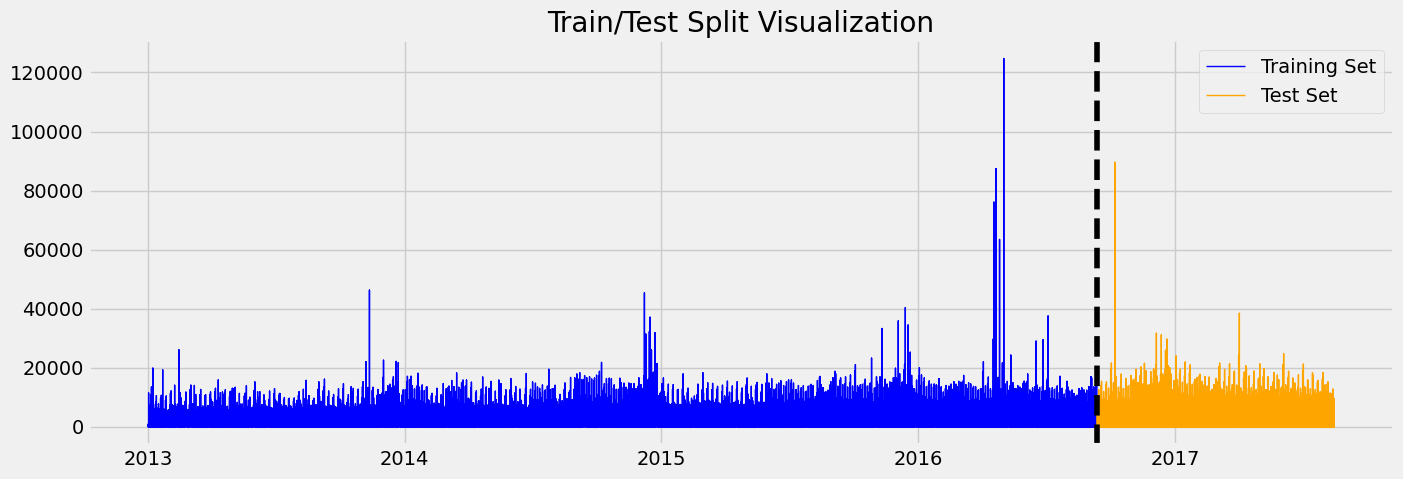

In [11]:
# Plot train-test split after splitting the dataset
fig, ax = plt.subplots(figsize=(15, 5))

# Create time index for plotting
train_index = X_train.index
test_index = X_test.index

# Plot the training set
ax.plot(train_index, y_train, label='Training Set', color='blue', linewidth=1)

# Plot the test set
ax.plot(test_index, y_test, label='Test Set', color='orange', linewidth=1)

# Draw a vertical line at the split point
split_date = train_index[-1]  # Last date of the training set
ax.axvline(split_date, color='black', ls='--')

# Add title and legend
ax.set_title('Train/Test Split Visualization')
ax.legend(['Training Set', 'Test Set'])

# Display the plot
plt.show()


#  XGBoost Model Training

In [12]:
# Define the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         early_stopping_rounds=50,
                         max_depth=10,
                         learning_rate=0.01,)

# Train the model
xgb_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1016.22256	validation_1-rmse:1358.59525
[100]	validation_0-rmse:518.28232	validation_1-rmse:709.90897
[200]	validation_0-rmse:370.83579	validation_1-rmse:502.98256
[300]	validation_0-rmse:319.44979	validation_1-rmse:447.74662
[400]	validation_0-rmse:290.85555	validation_1-rmse:437.93033
[481]	validation_0-rmse:272.38239	validation_1-rmse:443.00369


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance
The horizontal shows that the most used feature is onpromotion, followed by store_nbr, and then month, next is year, which is followed by day_of_week and day_of_year, and then day. The feature onpromotion is greatly correlated with sales, thus greatly influences the model.

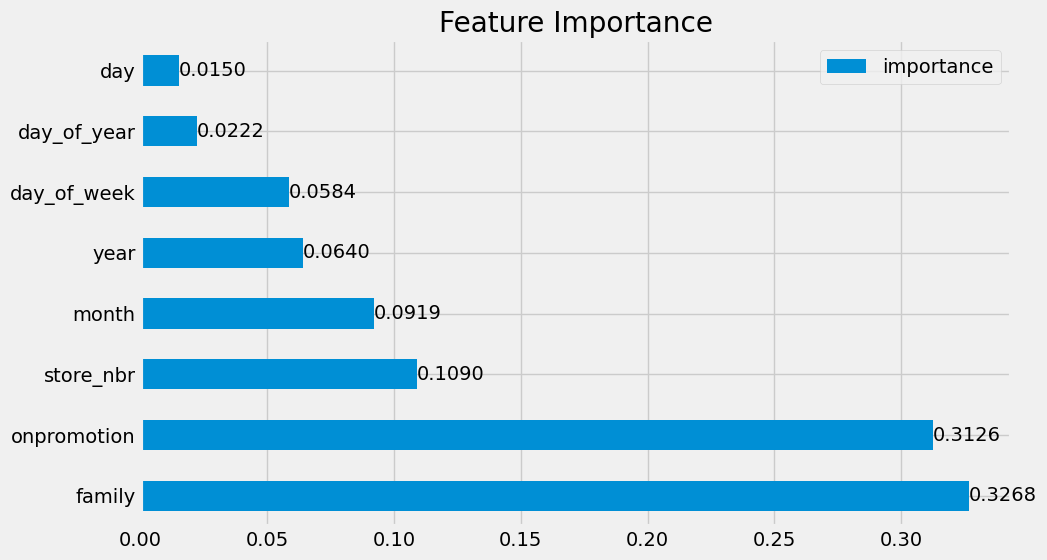

In [13]:
# Create the DataFrame for feature importance
f1 = pd.DataFrame(data=xgb_model.feature_importances_,
                  index=xgb_model.feature_names_in_,
                  columns=['importance']).sort_values(by='importance', ascending=False)

# Plot the feature importance
ax = f1.plot(kind='barh', title='Feature Importance', figsize=(10, 6))

# Add the importance values next to the bars
for index, value in enumerate(f1['importance']):
    ax.text(value, index, f'{value:.4f}', va='center')

plt.show()


# Model Evaluation

Mean Squared Error: 190431.17166362898
Mean Absolute Error: 131.12741299768422


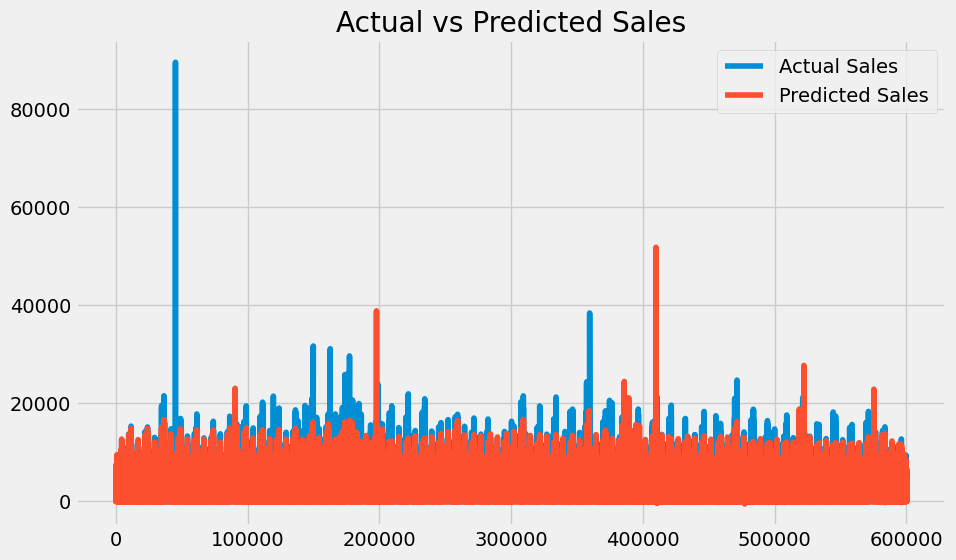

In [14]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plotting predictions vs actual
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()
